In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('ObsReward_A_04_26_2024_14_17_delta.csv')

print(df.head())

           Time                                             Events  HeadPosx  \
0  14:17:56:619                                 Started Experiment       NaN   
1  14:17:56:620                            anchor rotation ( pitch       NaN   
2  14:17:56:620    coinsetID:14 absolute and delta(local position)       NaN   
3  14:17:56:620  coinpoint0:  x: 9.878424 y: -1.662028 z: -3.98...       NaN   
4  14:17:56:620  coinpoint1:  x: 5.044029 y: -1.662028 z: -0.66...       NaN   

   HeadPosy  HeadPosz  GlobalBlock  
0       NaN       NaN            1  
1       NaN       NaN            1  
2       NaN       NaN            1  
3       NaN       NaN            1  
4       NaN       NaN            1  


In [3]:
high_values = [([-2.5, 1.9, 10.0], 'HV_1'), ([1.8, -3.1, 10.0], 'HV_2')]
low_values = [([2.8, 1.2, 2.0], 'LV_1'), ([-2.1, -2.2, 2.0], 'LV_2')]
null_values = [([0.75, 3.0, 0.0], 'NV_1'), ([0.2, -0.3, 0.0], 'NV_2')]
fixed_points = {}
for coords, label in high_values + low_values + null_values:
    fixed_points[label] = np.array(coords[:2])  # Only take the x and y coordinates


def find_closest_points(data):
    for index, row in data.iterrows():
        min_distance = np.inf
        closest_point = None
        current_pos = np.array([row['HeadPosx'], row['HeadPosz']])

        # Check distance to each fixed point
        for label, point in fixed_points.items():
            distance = np.linalg.norm(current_pos - point)
            if distance < min_distance:
                min_distance = distance
                closest_point = label

        data.at[index, 'Closest_Point'] = closest_point

    return data


    


starting_positions = [
        [[0.0, 5.0], [1.75, 4.25]],
        [[3.5, 3.5], [4.25, 1.75]],
        [[5.0, 0.0], [4.25, -1.75]],
        [[3.5, -3.5], [1.75, -4.25]],
        [[0.0, -5.0], [-1.75, -4.25]],
        [[-3.5, -3.5], [-4.25, -1.75]],
        [[-5.0, 0.0], [-4.25, 1.75]],
        [[-3.5, 3.5], [-1.75, 4.25]]
    ]


In [4]:
def plot_head_positions(filepath,trial):
    """
    Reads a CSV file, processes time data, drops missing values, and plots head positions.
    
    Parameters:
    - filepath: str, the path to the CSV file containing the data.
    """

    # 1. Read the CSV file
    df = pd.read_csv(filepath, error_bad_lines=False)
    
    # 2. Convert time strings to datetime objects including milliseconds
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S:%f')
    
    # 3. Convert datetime objects to seconds since the first timestamp
    df['Time_seconds'] = (df['Time'] - df['Time'].min()).dt.total_seconds()

    # 4. Select data of the desired trial (Global Block)
    df = df[df['GlobalBlock'] == trial]
    
    # 5. Create a scatter plot where color varies with time. Also, plot rewards. 
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df['HeadPosx'], df['HeadPosz'], c=df['Time_seconds'], cmap='viridis', alpha=0.5, s=0.5)

        # High Value Rewards
    for coord, label in high_values:
        plt.scatter(coord[0], coord[1], color='gold', edgecolor='black', s=100, label=f'{label} ({coord[2]} Points)', marker='o')
        # Low Value Rewards
    for coord, label in low_values:
        plt.scatter(coord[0], coord[1], color='silver', edgecolor='black', s=100, label=f'{label} ({coord[2]} Points)', marker='o')
        # Null Value Rewards
    for coord, label in null_values:
        plt.scatter(coord[0], coord[1], color='chocolate', edgecolor='black', s=100, label=f'{label} ({coord[2]} Points)', marker='o')

    # 6.  # Plot starting positions
    labels_set = False
    for pos_pair in starting_positions:
        plt.scatter(pos_pair[0][0], pos_pair[0][1], color='cornflowerblue', alpha=0.7, s=20, edgecolor='black', 
                label='AN Starting Position' if not labels_set else "", marker='x')
        plt.scatter(pos_pair[1][0], pos_pair[1][1], color='darkgrey', alpha=0.7, s=20, edgecolor='black', 
                label='PO Starting Position' if not labels_set else "", marker='x')
        labels_set = True  # Set labels_set to True after the first iteration
    
    # 7. Plot Coin Collection Locations
    mask = df['Events'].str.contains('Collected feedback coin', na=False)
    indices = df.index[mask]
    prev_indices = indices - 1
    prev_indices = prev_indices[prev_indices >= 0]
    previous_positions = df.loc[prev_indices, ['HeadPosx', 'HeadPosz']]
    plt.scatter(previous_positions['HeadPosx'],previous_positions['HeadPosz'], color='red', alpha=0.7, s=20, label='coin collection location', marker='s')

    # 8. Identify Order of Rewards
    coin_order=find_closest_points(previous_positions)
    print(coin_order)


    # 9. Graph Instructions
    plt.title('2D Scatter Plot of Head Positions with Time Color Encoding')
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1.2))
    plt.colorbar(scatter, label='Time_seconds')
    plt.show()


       HeadPosx  HeadPosz Closest_Point
11557 -2.285373  2.079653          HV_1
11938  2.337351 -1.185275          HV_2
12309  0.298482  2.866333          NV_1
12555 -0.226175  0.213156          NV_2
12784  2.450603  0.397012          LV_1
13776 -1.349906 -2.236295          LV_2


/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(filepath, error_bad_lines=False)
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:38: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[0][0], pos_pair[0][1], color='cornflowerblue', alpha=0.7, s=20, edgecolor='black',
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:40: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[1][0], pos_pair[1][1], color='darkgrey', alph

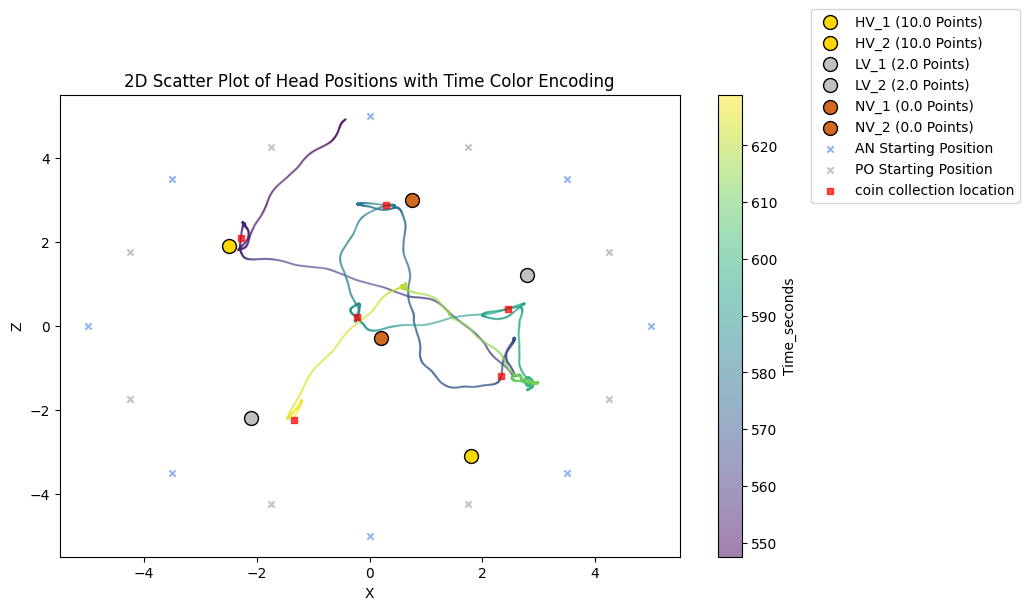

In [5]:
result= plot_head_positions('ObsReward_A_04_26_2024_14_17_delta.csv',9)

/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(filepath, error_bad_lines=False)
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:38: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[0][0], pos_pair[0][1], color='cornflowerblue', alpha=0.7, s=20, edgecolor='black',
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:40: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[1][0], pos_pair[1][1], color='darkgrey', alph

Empty DataFrame
Columns: [HeadPosx, HeadPosz]
Index: []


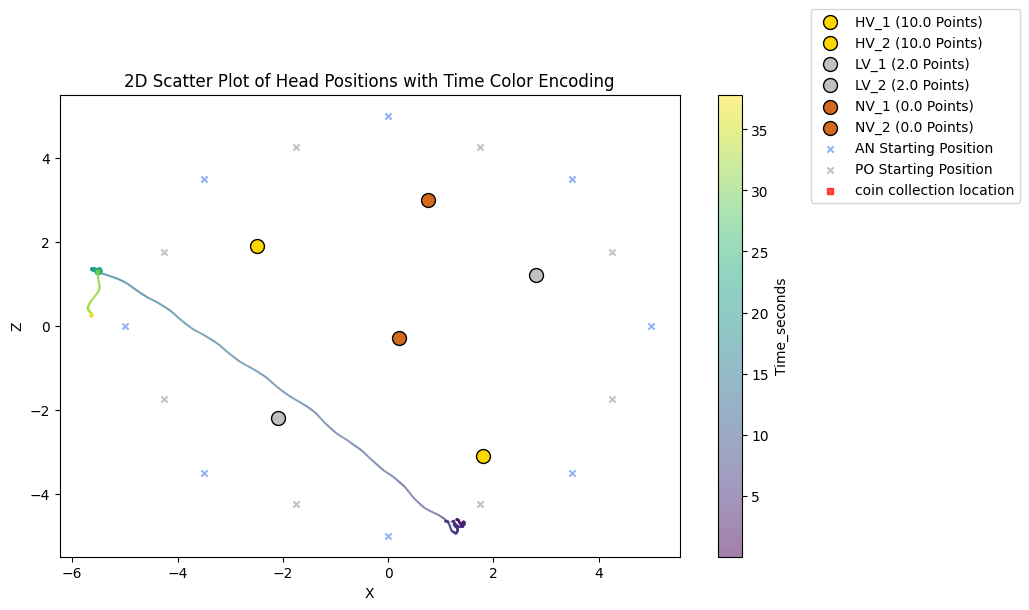

/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(filepath, error_bad_lines=False)
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:38: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[0][0], pos_pair[0][1], color='cornflowerblue', alpha=0.7, s=20, edgecolor='black',
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:40: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[1][0], pos_pair[1][1], color='darkgrey', alph

      HeadPosx  HeadPosz Closest_Point
1534 -5.646648  0.966230          HV_1
1707 -5.584262  0.820868          HV_1
1896 -5.506241  0.520893          HV_1


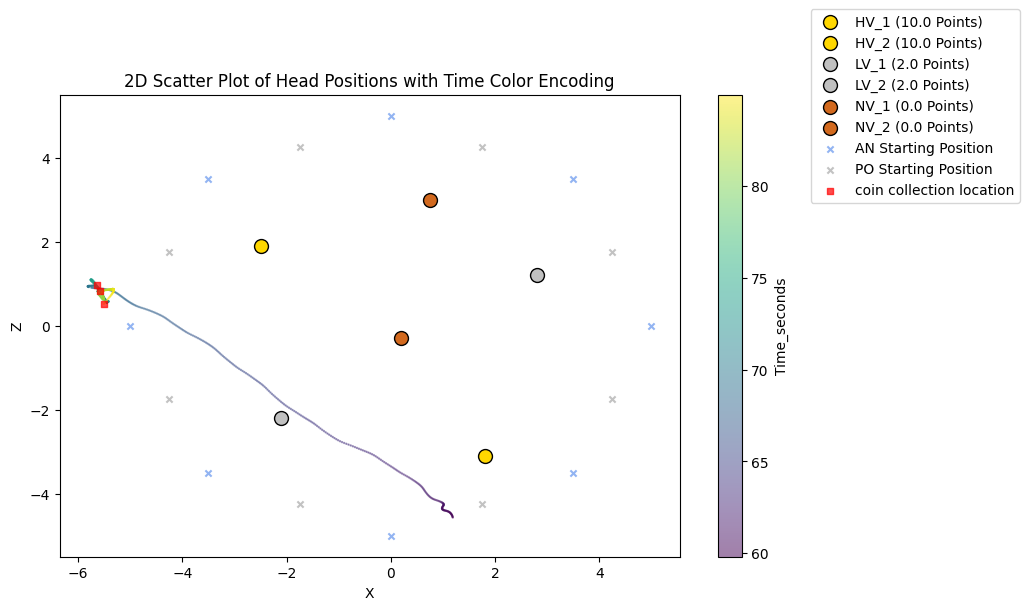

/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(filepath, error_bad_lines=False)
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:38: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[0][0], pos_pair[0][1], color='cornflowerblue', alpha=0.7, s=20, edgecolor='black',
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:40: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[1][0], pos_pair[1][1], color='darkgrey', alph

      HeadPosx  HeadPosz Closest_Point
2037 -5.640480  1.016581          HV_1
2216 -5.231689  0.860676          HV_1
2404 -5.302838  0.336340          HV_1


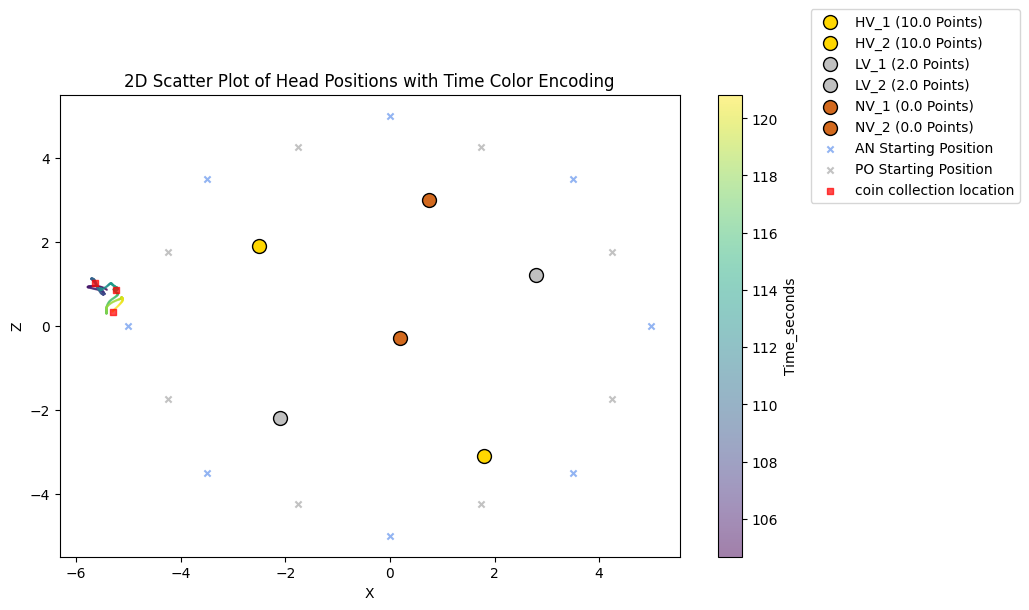

/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(filepath, error_bad_lines=False)
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:38: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[0][0], pos_pair[0][1], color='cornflowerblue', alpha=0.7, s=20, edgecolor='black',
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:40: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[1][0], pos_pair[1][1], color='darkgrey', alph

      HeadPosx  HeadPosz Closest_Point
2552 -5.662952  0.917180          HV_1
2693 -5.397752  0.755623          HV_1
2837 -5.349653  0.481257          HV_1


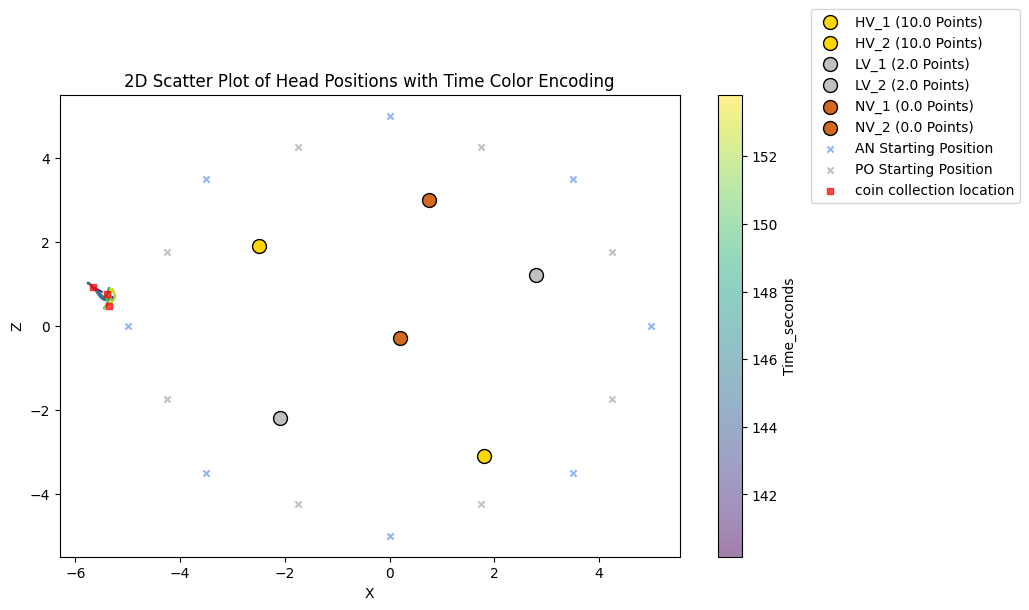

/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(filepath, error_bad_lines=False)
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:38: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[0][0], pos_pair[0][1], color='cornflowerblue', alpha=0.7, s=20, edgecolor='black',
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:40: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[1][0], pos_pair[1][1], color='darkgrey', alph

Empty DataFrame
Columns: [HeadPosx, HeadPosz]
Index: []


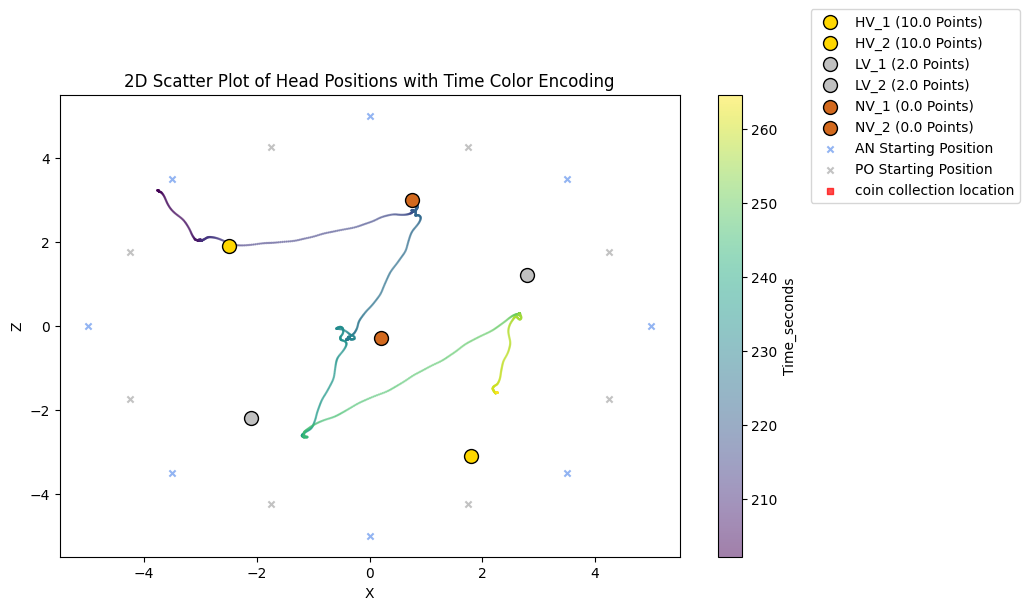

/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(filepath, error_bad_lines=False)
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:38: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[0][0], pos_pair[0][1], color='cornflowerblue', alpha=0.7, s=20, edgecolor='black',
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:40: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[1][0], pos_pair[1][1], color='darkgrey', alph

      HeadPosx  HeadPosz Closest_Point
5167 -2.892725  2.174340          HV_1
5608  0.505739  2.944033          NV_1
5908 -0.095832  0.334965          NV_2
6390 -1.091230 -2.309492          LV_2
6747  2.413383  0.294354          LV_1
7011  2.636614 -1.288126          HV_2


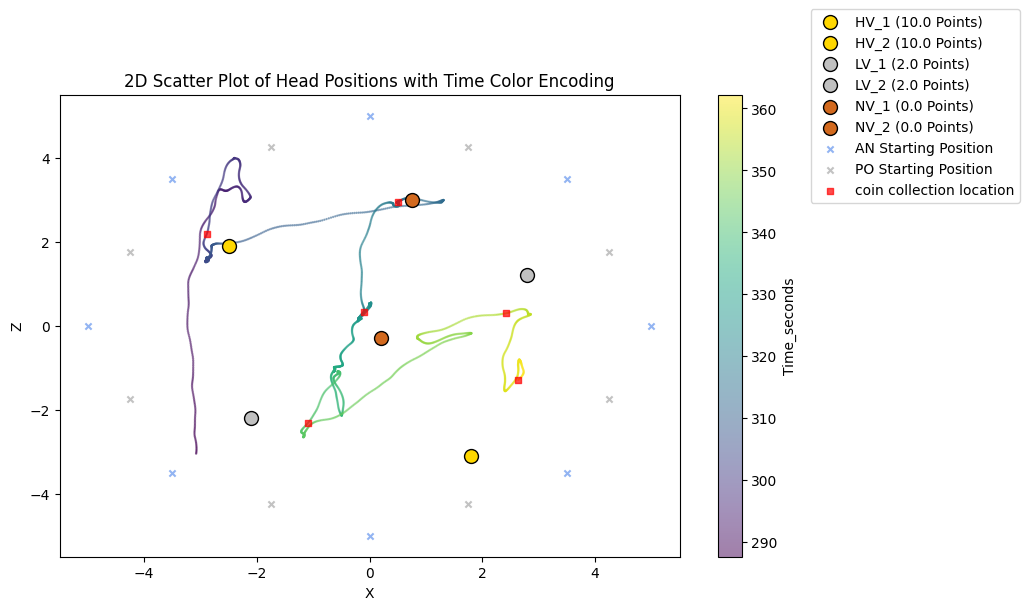

/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(filepath, error_bad_lines=False)
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:38: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[0][0], pos_pair[0][1], color='cornflowerblue', alpha=0.7, s=20, edgecolor='black',
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:40: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[1][0], pos_pair[1][1], color='darkgrey', alph

      HeadPosx  HeadPosz Closest_Point
7368 -2.596387  2.046127          HV_1
7734  0.645509  3.075183          NV_1
8018 -0.294615  0.226613          NV_2
8332 -1.540687 -2.239429          LV_2
8629  2.428650  0.363654          LV_1
9061  1.928190 -1.179391          HV_2


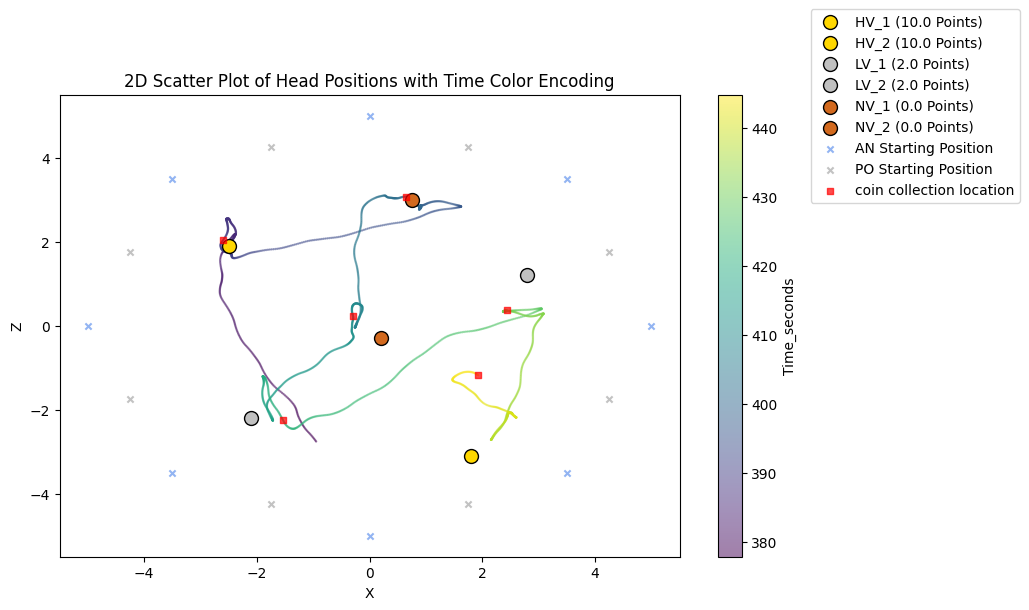

/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(filepath, error_bad_lines=False)
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:38: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[0][0], pos_pair[0][1], color='cornflowerblue', alpha=0.7, s=20, edgecolor='black',
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:40: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[1][0], pos_pair[1][1], color='darkgrey', alph

       HeadPosx  HeadPosz Closest_Point
9308  -3.020938  2.172505          HV_1
9660   2.405992 -1.133850          HV_2
10067  0.407045  3.138545          NV_1
10681 -0.345654  0.360909          NV_2
10989 -1.100073 -2.141521          LV_2
11292  2.781946  0.471467          LV_1


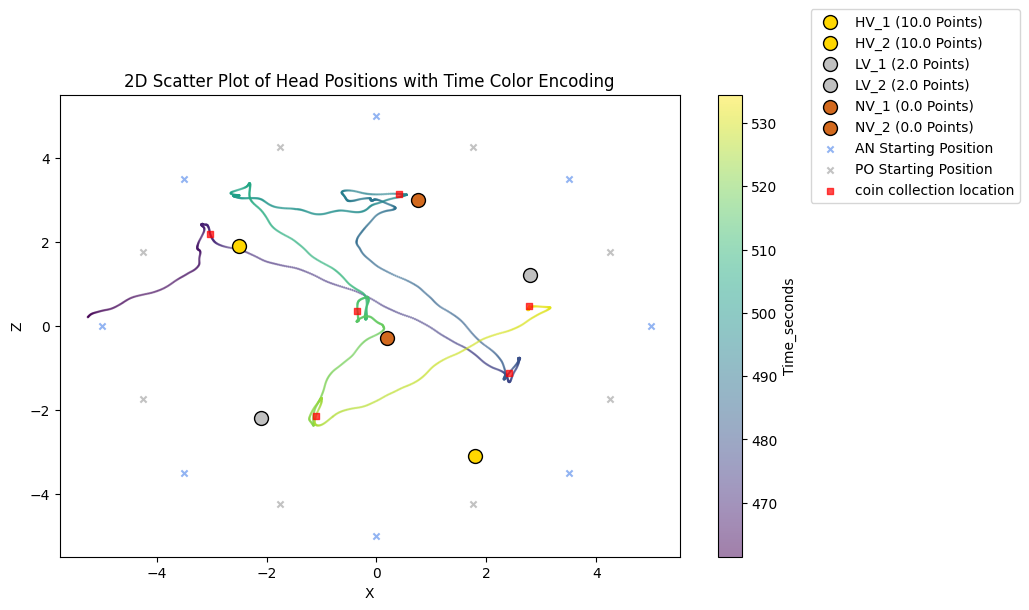

/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(filepath, error_bad_lines=False)
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:38: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[0][0], pos_pair[0][1], color='cornflowerblue', alpha=0.7, s=20, edgecolor='black',
/var/folders/88/40j_qx5n2s7c19vfm424262c0000gn/T/ipykernel_56933/1609353479.py:40: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_pair[1][0], pos_pair[1][1], color='darkgrey', alph

       HeadPosx  HeadPosz Closest_Point
11557 -2.285373  2.079653          HV_1
11938  2.337351 -1.185275          HV_2
12309  0.298482  2.866333          NV_1
12555 -0.226175  0.213156          NV_2
12784  2.450603  0.397012          LV_1
13776 -1.349906 -2.236295          LV_2


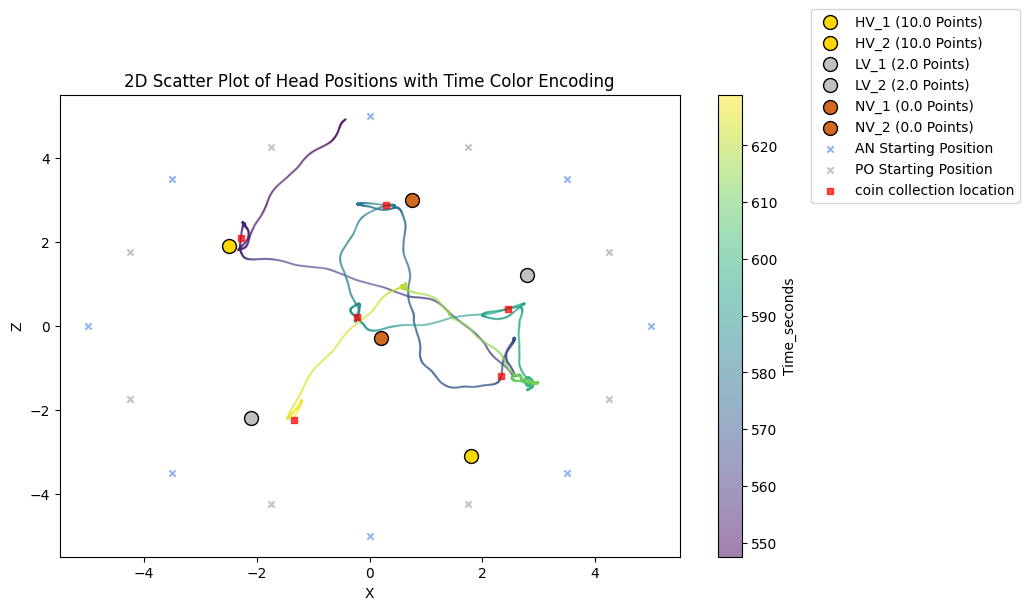

In [6]:
all_trials_data = {}
for trial_number in range(1, 10):  # Assuming there are 9 trials
    result = plot_head_positions('ObsReward_A_04_26_2024_14_17_delta.csv', trial_number)
    all_trials_data[trial_number] = result

Plan：
0. Plot the path wrt to anchor - DONE
1. Plot the reward points, plot different values (see collab) - DONE
2. Separate the different events (separate the encoding stage, separate 1,2,3,4,5,etc.) - DONE
3. Compute the theoretical order/path 
4. Classify the types of path type (computing where the location before collecting a coin is (compute the orders and absolute value). computing the entire path. ) 
5. Quantify the difference between actual v.s. ideal path. 
Future:
- Examine learning with questionnaire, biometrics. 
- Include speed information


strategy 1: going to the closest point of where you're at (maximizes efficiency)
strategy 2: going to the closest point that is most valued (maximizes reward)
strategy 3: going to the most valued first, then maximize efficiency
strategy 4: going according to initial learned path 



Timeline:
1. Data Collection Monday 21st
2. Presentation Tuesday
3. Collect More Data
4. By the end of quater: quantify learning. 